<a href="https://colab.research.google.com/github/GiovaniValdrighi/inferencia_causal/blob/master/vae/scm_counterfactual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [130]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [132]:
!pip3 install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl
!pip3 install torchvision
!pip3 install pyro-ppl

ERROR: torch-0.4.0-{platform}-linux_x86_64.whl is not a valid wheel filename.


In [0]:
import numpy as np
import torch
from vae_build import VAE, ind_from_att, label_from_dummy
import pyro
import matplotlib.pyplot as plt
from pyro.distributions import OneHotCategorical, RelaxedOneHotCategorical, Normal, Uniform, constraints
from torch import tensor

In [134]:
dataset_zip = np.load('/content/gdrive/My Drive/autoencoder/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz', allow_pickle = True, encoding = 'bytes')
print('Keys in the dataset:', dataset_zip.files)
imgs = dataset_zip['imgs']
latents_values = dataset_zip['latents_values']
latents_classes = dataset_zip['latents_classes']
latents_sizes = dataset_zip['metadata'][()][b'latents_sizes']
latents_names = dataset_zip['metadata'][()][b'latents_names']

Keys in the dataset: ['metadata', 'imgs', 'latents_classes', 'latents_values']


In [135]:
pyro.enable_validation(True)
pyro.clear_param_store()
#the training routine
use_CUDA = False
vae = VAE(latents_sizes, latents_names, use_CUDA = use_CUDA)
vae.load_state_dict(torch.load('/content/gdrive/My Drive/trained_movel_epoch_24.save'))

<All keys matched successfully>

def condition(cond_values, n_steps = 1000):
      #calculating noise posterior in the observation model
      condModel = pyro.condition(model, data = cond_values)
      pyro.clear_param_store()

      #setting the SVI attributes
      adam_params = {'lr': 0.001}
      optmizer = pyro.optim.Adam(adam_params)
      elbo = pyro.infer.Trace_ELBO()
      svi = pyro.infer.SVI(condModel, guide, optmizer, elbo)

      #training loop
      losses = []
      mu_samples = {key: [] for key in self.init_noise.keys()}
      sigma_samples = {key: [] for key in self.init_noise.keys()}

      for i in range(n_steps):
        losses.append(svi.step(self.init_noise))
        #saving samples
        for key in self.init_noise.keys():
          mu_samples[key].append(pyro.param('mu_'+key))
          sigma_samples[key].append(pyro.param('sigma_'+key))

      #calculating means
      mean_samples = {}
      mean_samples['mu'] = {key: [] for key in self.init_noise.keys()}
      mean_samples['sigma'] = {key: [] for key in self.init_noise.keys()}
      for key in self.init_noise.keys():
        mean_samples['mu'][key] = torch.mean(torch.stack(mu_samples[key]), dim = 0)
        mean_samples['sigma'][key] = torch.mean(torch.stack(sigma_samples[key]), dim = 0)

      print(mean_samples)
      updated_noise = {}
      for key in self.init_noise.keys():
        updated_noise[key] = Normal(mean_samples['mu'][key], mean_samples['sigma'][key])

      img_samples = []
      for _ in range(1000):
        _, _, s = model(updated_noise)
        img_samples.append(s)
      img_samples = torch.mean(torch.stack(img_samples), dim = 0)
      print(losses)
      plt.figure()
      plt.plot(losses)
      plt.figure()
      plt.imshow(img_samples.detach().numpy().reshape(64, 64))
      plt.show()
      

    def counterfactual(var_name, obs_var, counter_var, n_steps = 1000):
      #calculating noise posterior in the observation model
      obsModel = pyro.condition(model, data = {var_name : obs_var})
      pyro.clear_param_store()

      #setting the SVI attributes
      adam_params = {'lr': 0.001}
      optmizer = pyro.optim.Adam(adam_params)
      elbo = pyro.infer.Trace_ELBO()
      svi = pyro.infer.SVI(obsModel, guide, optmizer, elbo)

      #training loop
      losses = []
      noise_samples = {latent:[] for latent in self.latents_names}
      noise_samples['latent'] = {'mu':[], 'sigma': []}
      noise_samples['img'] = {'low':[], 'high': []}

      for i in range(n_steps):
        losses.append(svi.step(self.init_noise))
        #print(losses[-1])
        #saving samples
        for latent in self.latents_names:
          noise_samples[latent].append(pyro.param('prob_'+latent))
        noise_samples['latent']['mu'].append(pyro.param('mu_latent'))
        noise_samples['latent']['sigma'].append(pyro.param('sigma_latent'))
        noise_samples['img']['low'].append(pyro.param('low_img'))
        noise_samples['img']['high'].append(pyro.param('high_img'))

      #calculating means
      mean_values = {latent:[] for latent in self.latents_names}
      mean_values['latent'] = {'mu':[], 'sigma': []}
      mean_values['img'] = {'low':[], 'high': []}
      for latent in self.latents_names:
        mean_values[latent] = torch.mean(torch.stack(noise_samples[latent]), dim = 0)
      mean_values['latent']['mu'] = torch.mean(torch.stack(noise_samples['latent']['mu']), dim = 0)
      mean_values['latent']['sigma'] = torch.mean(torch.stack(noise_samples['latent']['sigma']), dim = 0)
      mean_values['img']['low'] = torch.mean(torch.stack(noise_samples['img']['low']), dim = 0)
      mean_values['img']['high'] = torch.mean(torch.stack(noise_samples['img']['high']), dim = 0)

      updated_noise = {}
      for latent in self.latents_names:
        updated_noise[latent] = OneHotCategorical(mean_values[latent])
      updated_noise['latent'] = Normal(mean_values['latent']['mu'], mean_values['latent']['sigma'])
      updated_noise['img'] = Normal(mean_values['img']['low'], mean_values['img']['high'])

      #counterfactual query with updated noise
      intModel = pyro.do(model, data = {var_name : counter_var})
      cf_posterior = pyro.infer.Importance(intModel, guide, n_steps).run(updated_noise)
      cf_marginal = pyro.infer.EmpiricalMarginal(cf_posterior, sites = 'img')
      plt.imshow(cf_marginal.mean.detach().numpy().reshape(64, 64), cmap = 'Greys')
      plt.show()

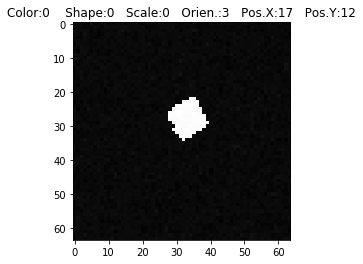

In [150]:
class SCM():
  def __init__(self, vae):
    self.vae = vae
    self.latents_names = ['color', 'shape', 'scale', 'orien', 'posX', 'posY']
    self.latents_sizes = {'color' : 1, 'shape': 3, 'scale':6, 'orien': 40, 'posX': 32, 'posY':32}
    dist = OneHotCategorical
    self.init_noise = {'color': dist(tensor([1.])),
                       'shape': dist(tensor([0.4, 0.4, 0.2])),
                       'scale': dist(tensor([1/6]).repeat(6)),
                       'orien': dist(tensor([1/40]).repeat(40)),
                       'posX': dist(tensor([1/32]).repeat(32)),
                       'posY': dist(tensor([1/32]).repeat(32)),
                       'latent': Normal(torch.zeros(200), torch.ones(200)),
                       'img': Uniform(torch.zeros(4096), torch.ones(4096))}
    
    #functions for the model
    def f_gumbel(N):
      return N
    
    def f_posX(N, scale):
      if 31 <= int(scale.max(0)[1] + N.max(0)[1]):
        return torch.nn.functional.one_hot(torch.tensor([31]), 32).to(torch.float32).reshape([32])
      else:
        return torch.nn.functional.one_hot(scale.max(0)[1] + N.max(0)[1], 32).to(torch.float32).reshape([32])

    def f_latent(N_latent, color, shape, scale, orien, posX, posY):
      ind = ind_from_att(color.max(0)[1], shape.max(0)[1], scale.max(0)[1], orien.max(0)[1], posX.max(0)[1], posY.max(0)[1])
      label = torch.round(torch.cat([color, shape, scale, orien, posX, posY], -1))
      mu, sigma = vae.encoder.forward(torch.tensor(imgs[ind]).reshape(4096).to(torch.float32), label)
      return N_latent * sigma + mu

    def f_image(N_img, latent, color, shape, scale, orien, posX, posY):
      label = torch.round(torch.cat([color, shape, scale, orien, posX, posY], -1))
      img_decode = vae.decoder.forward(latent, label)
      return (N_img > img_decode).to(torch.float)

 
    def model(noise = self.init_noise):

      #Noise variables
      N_color = pyro.sample('N_color', noise['color'])
      N_shape = pyro.sample('N_shape', noise['shape'])
      N_scale = pyro.sample('N_scale', noise['scale'])
      N_orien = pyro.sample('N_orien', noise['orien'])
      N_posX = pyro.sample('N_posX', noise['posX'])
      N_posY = pyro.sample('N_posY', noise['posY'])
      N_latent = pyro.sample('N_latent', noise['latent'].to_event(1))
      N_img = pyro.sample('N_img', noise['img'].to_event(1))

      #variables
      color = pyro.sample('color', Normal(f_gumbel(N_color), torch.tensor([0.01])).to_event(1))
      shape = pyro.sample('shape', Normal(f_gumbel(N_shape), torch.tensor([0.01])).to_event(1))
      scale = pyro.sample('scale', Normal(f_gumbel(N_scale), torch.tensor([0.01])).to_event(1))
      orien = pyro.sample('orien', Normal(f_gumbel(N_orien), torch.tensor([0.01])).to_event(1))
      posX = pyro.sample('posX', Normal(f_posX(N_posX, scale), torch.tensor([0.01])).to_event(1))
      posY = pyro.sample('posY', Normal(f_gumbel(N_posY), torch.tensor([0.01])).to_event(1))

      #variables
      latent = pyro.sample('latent', Normal(f_latent(N_latent, color, shape, scale, orien, posX, posY), torch.tensor([0.01])).to_event(1))
      img = pyro.sample('img', Normal(f_image(N_img, latent, color, shape, scale, orien, posX, posY), torch.tensor([0.01])).to_event(1))

      return torch.round(torch.cat([color, shape, scale, orien, posX, posY], -1)), latent, img
    
    def guide(noise = self.init_noise):
      
      #params
      cat_val =  {'color': 1, 'shape': 3, 'scale': 6, 'orien': 40, 'posX': 32, 'posY': 32}
      probs = {key : pyro.param('prob_'+key, tensor(1/value).repeat(value), constraint = constraints.positive) for key, value in cat_val.items()}
      mu_latent = pyro.param('mu_latent', torch.ones(200)*0.5)
      sigma_latent = pyro.param('sigma_latent', torch.ones(200)*0.2, constraint = constraints.positive)
      low_img = pyro.param('low_img', torch.ones(4096)*0.5, constraint = constraints.interval(0., 1.))
      high_img = pyro.param('high_img', torch.ones(4096)*0.02, constraint = constraints.interval(0., 1.))
      
      #noise variables
      N_color = pyro.sample('N_color', OneHotCategorical(probs['color']))
      N_shape = pyro.sample('N_shape', OneHotCategorical(probs['shape']))
      N_scale = pyro.sample('N_scale', OneHotCategorical(probs['scale']))
      N_orien = pyro.sample('N_orien', OneHotCategorical(probs['orien']))
      N_posX = pyro.sample('N_posX', OneHotCategorical(probs['posX']))
      N_posY = pyro.sample('N_posY', OneHotCategorical(probs['posY']))
      N_latent = pyro.sample('N_latent', Normal(mu_latent, sigma_latent).to_event(1))
      N_img = pyro.sample('N_img', Normal(low_img, high_img).to_event(1))
      #print(sum(N_img > 1))
      #print(sum(N_img < 0))
      #variables
      color = pyro.sample('color', Normal(f_gumbel(N_color), tensor(0.01)).to_event(1), infer = {'is_auxiliary' : True})
      shape = pyro.sample('shape', Normal(f_gumbel(N_shape), tensor(0.01)).to_event(1), infer = {'is_auxiliary' : True})
      scale = pyro.sample('scale', Normal(f_gumbel(N_scale), tensor(0.01)).to_event(1), infer = {'is_auxiliary' : True})
      orien = pyro.sample('orien', Normal(f_gumbel(N_orien), tensor(0.01)).to_event(1), infer = {'is_auxiliary' : True})
      posX = pyro.sample('posX', Normal(f_gumbel(N_posX), tensor(0.01)).to_event(1), infer = {'is_auxiliary' : True})
      posY = pyro.sample('posY', Normal(f_gumbel(N_posY), tensor(0.01)).to_event(1), infer = {'is_auxiliary' : True})
      latent = pyro.sample('latent', Normal(f_latent(N_latent, color, shape, scale, orien, posX, posY), tensor(0.01)).to_event(1))
      img = pyro.sample('img', Normal(f_image(N_img, latent, color, shape, scale, orien, posX, posY), tensor(0.01)).to_event(1))

      return 
    
    

    def viz_model():
      label, _, img = model()
      label = label_from_dummy(label)
      plt.imshow(img.detach().numpy().reshape(64, 64), cmap = 'Greys')
      text = 'Color:0    Shape:'+str(int(label[1])) + '   Scale:' + str(int(label[2])) + '   Orien.:' + str(int(label[3])) + '   Pos.X:' + str(int(label[4])) + '   Pos.Y:' + str(int(label[5]))
      plt.title(text)
      plt.show()

    self.model = model
    self.guide = guide
    self.viz_model = viz_model


scm = SCM(vae)
scm.viz_model()

In [151]:
#condition algoritm
obs = {'color': tensor([1.]),
      'shape': tensor([0., 1., 0.]),
      'orien': torch.zeros(40),
      'posX': torch.zeros(32),
      'posY': torch.zeros(32)}
obs['orien'][17] = 1.
obs['posY'][3] = 1.
obs['posX'][4] = 1.
obs['scale'] = tensor([1.0, 0., 0., 0., 0., 0.])
condModel = pyro.condition(scm.model, data = obs)
pyro.clear_param_store()

var_shapes = {'color': 1, 'shape':3, 'scale':6, 'orien':40, 'posX':32, 'posY':32}

#setting the SVI attributes
adam_params = {'lr': 0.01}
optmizer = pyro.optim.Adam(adam_params)
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(condModel, scm.guide, optmizer, elbo)

#training loop
losses = []
prob_samples = {key : [] for key in var_shapes.keys()}
mu_samples = []
sigma_samples = []
low_samples = []
high_samples = []

for i in range(500):
  losses.append(svi.step(scm.init_noise))
  #saving samples
  for key in var_shapes.keys():
    prob_samples[key].append(pyro.param('prob_'+key))
  mu_samples.append(pyro.param('mu_latent'))
  sigma_samples.append(pyro.param('sigma_latent'))
  low_samples.append(pyro.param('low_img'))
  high_samples.append(pyro.param('high_img'))

#calculating means
for key in var_shapes.keys():
  prob_samples[key] = torch.mean(torch.stack(prob_samples[key]), dim = 0)
mu_samples = torch.mean(torch.stack(mu_samples), dim = 0)
sigma_samples = torch.mean(torch.stack(sigma_samples), dim = 0)
low_samples = torch.mean(torch.stack(low_samples),dim = 0)
high_samples = torch.mean(torch.stack(high_samples), dim = 0)

updated_noise = {}
for key in var_shapes.keys():
  updated_noise[key] = OneHotCategorical( prob_samples[key])
updated_noise['latent'] = Normal(mu_samples, sigma_samples)
updated_noise['img'] =  Normal(low_samples, high_samples)
img_samples = []
for _ in range(1000):
  _, _, s = scm.model(updated_noise)
  img_samples.append(s)
img_samples = torch.mean(torch.stack(img_samples), dim = 0)
print(prob_samples)

{'color': tensor([1.], grad_fn=<MeanBackward1>), 'shape': tensor([0.3325, 0.3336, 0.3344], grad_fn=<MeanBackward1>), 'scale': tensor([0.1682, 0.1675, 0.1670, 0.1668, 0.1662, 0.1661],
       grad_fn=<MeanBackward1>), 'orien': tensor([0.0250, 0.0251, 0.0250, 0.0250, 0.0251, 0.0250, 0.0253, 0.0251, 0.0250,
        0.0250, 0.0250, 0.0251, 0.0251, 0.0250, 0.0251, 0.0250, 0.0250, 0.0251,
        0.0252, 0.0251, 0.0251, 0.0250, 0.0252, 0.0251, 0.0250, 0.0250, 0.0251,
        0.0251, 0.0252, 0.0250, 0.0250, 0.0250, 0.0250, 0.0252, 0.0253, 0.0251,
        0.0251, 0.0254, 0.0250, 0.0252], grad_fn=<MeanBackward1>), 'posX': tensor([0.0312, 0.0318, 0.0314, 0.0313, 0.0313, 0.0314, 0.0313, 0.0313, 0.0313,
        0.0315, 0.0313, 0.0313, 0.0313, 0.0313, 0.0313, 0.0315, 0.0314, 0.0314,
        0.0315, 0.0313, 0.0314, 0.0312, 0.0313, 0.0313, 0.0314, 0.0312, 0.0313,
        0.0313, 0.0312, 0.0313, 0.0314, 0.0312], grad_fn=<MeanBackward1>), 'posY': tensor([0.0314, 0.0313, 0.0315, 0.0313, 0.0313, 0.0314, 0

In [146]:
low_samples

tensor([0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
       grad_fn=<MeanBackward1>)

In [0]:
high_samples

[tensor([1.0008, 1.0008, 1.0008,  ..., 1.0008, 1.0008, 1.0008],
        requires_grad=True),
 tensor([1.0008, 1.0008, 1.0008,  ..., 1.0008, 1.0008, 1.0008],
        requires_grad=True),
 tensor([1.0008, 1.0008, 1.0008,  ..., 1.0008, 1.0008, 1.0008],
        requires_grad=True),
 tensor([1.0008, 1.0008, 1.0008,  ..., 1.0008, 1.0008, 1.0008],
        requires_grad=True),
 tensor([1.0008, 1.0008, 1.0008,  ..., 1.0008, 1.0008, 1.0008],
        requires_grad=True),
 tensor([1.0008, 1.0008, 1.0008,  ..., 1.0008, 1.0008, 1.0008],
        requires_grad=True),
 tensor([1.0008, 1.0008, 1.0008,  ..., 1.0008, 1.0008, 1.0008],
        requires_grad=True),
 tensor([1.0008, 1.0008, 1.0008,  ..., 1.0008, 1.0008, 1.0008],
        requires_grad=True),
 tensor([1.0008, 1.0008, 1.0008,  ..., 1.0008, 1.0008, 1.0008],
        requires_grad=True),
 tensor([1.0008, 1.0008, 1.0008,  ..., 1.0008, 1.0008, 1.0008],
        requires_grad=True),
 tensor([1.0008, 1.0008, 1.0008,  ..., 1.0008, 1.0008, 1.0008],
      

In [161]:
#initial_noise = {'A': OneHotCategorical(probs = tensor([0.3, 0.1, 0.6]))}
initial_noise = {'A': Uniform(tensor(0.), tensor(1.))}

def f_A(N):
  return N

def model(noise):
  N_A = pyro.sample('N_A', noise['A'])
  A = pyro.sample('A', pyro.distributions.Normal(f_A(N_A), tensor(0.01)))
  return A

def guide(noise):
  #prob_A = pyro.param('A_probs', tensor([1/3]).repeat(3), constraint = constraints.positive)
  #N_A = pyro.sample('N_A', OneHotCategorical(probs = prob_A))
  mu_A = pyro.param('A_mu', tensor(0.4), constraint = constraints.interval(0., 1.))
  sigma_A = pyro.param('A_sigma', tensor(0.2), constraint = constraints.interval(0., 1.))
  pyro.sample('N_A', Normal(mu_A, sigma_A))

condModel = pyro.condition(model, data = {'A': tensor(0.6)})
pyro.clear_param_store()

#setting the SVI attributes
adam_params = {'lr': 0.01}
optmizer = pyro.optim.Adam(adam_params)
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(condModel, guide, optmizer, elbo)

#training loop
#prob_samples = []
mu_samples = []
sigma_samples = []
losses = []
for i in range(1000):
  losses.append(svi.step(initial_noise))
  #saving samples
  #prob_samples.append(pyro.param('A_probs'))
  mu_samples.append(pyro.param('A_mu'))
  sigma_samples.append(pyro.param('A_sigma'))
#prob_samples = torch.mean(torch.stack(prob_samples), dim = 0)
mu_samples = torch.mean(torch.stack(mu_samples), dim = 0)
sigma_samples = torch.mean(torch.stack(sigma_samples), dim = 0)

updated_noise = {'A': Normal(mu_samples, sigma_samples)}
A_samples = []
for _ in range(1000):
  s = model(updated_noise)
  A_samples.append(s)
A_samples = torch.mean(torch.stack(A_samples), dim = 0)

A_samples      

tensor(0.5870, grad_fn=<MeanBackward1>)

In [155]:
model(initial_noise)

tensor(0.4050)

In [159]:
model(updated_noise)

tensor(0.5733, grad_fn=<AddBackward0>)

In [160]:
print(mu_samples, sigma_samples)

tensor(0.5855, grad_fn=<MeanBackward1>) tensor(0.0671, grad_fn=<MeanBackward1>)


In [0]:
small = 0
large = 0
for i in range(len(losses)):
  if losses[i] < 3:
    small += 1
  else:
    large +=1

In [0]:
print(small, large)

859 141


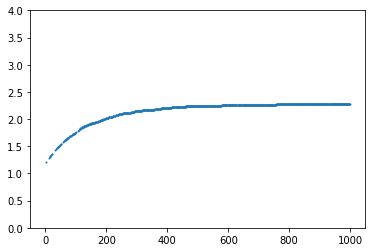

In [0]:
plt.scatter(range(len(losses)), losses, s = 1)
plt.ylim(0, 4)
plt.show()

In [0]:
losses

[10104.669674873352,
 10059.394067287445,
 1.2171294689178467,
 10034.824903130531,
 9905.481527805328,
 9959.031890153885,
 9855.651611566544,
 9934.827205777168,
 9953.732473134995,
 10272.443922400475,
 9860.217040777206,
 10029.26952791214,
 1.291888952255249,
 10039.333820819855,
 1.3072712421417236,
 1.314287543296814,
 1.3206193447113037,
 9972.985225200653,
 10042.868489980698,
 1.3390775918960571,
 9952.594079732895,
 1.3513746857643127,
 10021.673749446869,
 1.3633298873901367,
 10203.436838269234,
 9914.71223950386,
 9808.053092360497,
 9797.758408784866,
 10089.483631491661,
 9800.75064754486,
 10249.307907938957,
 9969.912957310677,
 9940.631183505058,
 1.433724820613861,
 9905.083116292953,
 10281.948043942451,
 1.455955445766449,
 10108.490466117859,
 1.4699680805206299,
 1.4764153957366943,
 1.4822546243667603,
 1.4875444173812866,
 1.4923377633094788,
 1.4966819286346436,
 1.500619888305664,
 9863.27238035202,
 9977.334928631783,
 10075.256103754044,
 1.518766522407531

In [0]:
Uniform(tensor(-1.), tensor(-2.)).sample()

ValueError: ignored

In [0]:
initial_noise = {'A': Uniform(tensor(0.), tensor(1.))}

def f_A(N):
  return N

def model(noise):
  N_A = pyro.sample('N_A', noise['A'])
  A = pyro.sample('A', pyro.distributions.Normal(f_A(N_A), tensor(0.01)).to_event(1))
  return A

def guide(noise):
  mu_A = pyro.param('A_probs', tensor([1/3]).repeat(3), constraint = constraints.positive)
  
  N_A = pyro.sample('N_A', OneHotCategorical(probs = prob_A))


condModel = pyro.condition(model, data = {'A': tensor([0., 1., 0.])})
pyro.clear_param_store()

#setting the SVI attributes
adam_params = {'lr': 0.01}
optmizer = pyro.optim.Adam(adam_params)
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(condModel, guide, optmizer, elbo)

#training loop
prob_samples = []
losses = []
for i in range(1000):
  losses.append(svi.step(initial_noise))
  #saving samples
  prob_samples.append(pyro.param('A_probs'))

prob_samples = torch.mean(torch.stack(prob_samples), dim = 0)

updated_noise = {'A': OneHotCategorical(prob_samples)}
A_samples = []
for _ in range(1000):
  s = model(updated_noise)
  A_samples.append(s)
A_samples = torch.mean(torch.stack(A_samples), dim = 0)

A_samples      

In [200]:
def t_mean(tens):
  return torch.mean(torch.stack(tens), dim = 0)

class SCM_test():
  def __init__(self, vae):
    self.vae = vae
    self.latents_names = ['shape', 'scale', 'orien', 'posX', 'posY']
    dist = OneHotCategorical
    self.init_noise = {'shape': dist(tensor([.4, .4, .2])),
                       'scale': dist(tensor([1., 2., 2., 2., 2., 1.])),
                       'orien': dist(tensor(1/40).repeat(40)),
                       'posY': dist(tensor(1/32).repeat(32))}
    
    def f_cat(N):
      return N

    def model(noise  = self.init_noise):
      #noise variables
      N_shape = pyro.sample('N_shape', noise['shape'])
      N_scale = pyro.sample('N_scale', noise['scale'])
      N_orien = pyro.sample('N_orien', noise['orien'])
      N_posY = pyro.sample('N_posY', noise['posY'])
      #variables
      shape = pyro.sample('shape', Normal(f_cat(N_shape), tensor(0.01)).to_event(1))
      scale = pyro.sample('scale', Normal(f_cat(N_scale), tensor(0.01)).to_event(1))
      orien = pyro.sample('orien', Normal(f_cat(N_orien), tensor(0.01)).to_event(1))
      posY = pyro.sample('posY', Normal(f_cat(N_posY), tensor(0.01)).to_event(1))
      return shape, scale, orien, posY

    def guide(noise = self.init_noise):
      #noise params
      prob_shape = pyro.param('prob_shape', tensor(1/3).repeat(3), constraint = constraints.positive)
      prob_scale = pyro.param('prob_scale', tensor(1/6).repeat(6), constraint = constraints.positive)
      prob_orien = pyro.param('prob_orien', tensor(1/40).repeat(40), constraint = constraints.positive)
      prob_posY = pyro.param('prob_posY', tensor(1/32).repeat(32), constraint = constraints.positive)
      #noise variables
      N_shape = pyro.sample('N_shape', OneHotCategorical(prob_shape))
      N_scale = pyro.sample('N_scale', OneHotCategorical(prob_scale))
      N_orien = pyro.sample('N_orien', OneHotCategorical(prob_orien))
      N_posY= pyro.sample('N_posY', OneHotCategorical(prob_posY))
      #variables
      shape = pyro.sample('shape', Normal(f_cat(N_shape), tensor(0.01)).to_event(1), infer={'is_auxiliary': True})
      scale = pyro.sample('scale', Normal(f_cat(N_scale), tensor(0.01)).to_event(1), infer={'is_auxiliary': True})
      orien = pyro.sample('orien', Normal(f_cat(N_orien), tensor(0.01)).to_event(1), infer={'is_auxiliary': True})
      posY = pyro.sample('posY', Normal(f_cat(N_posY), tensor(0.01)).to_event(1), infer={'is_auxiliary': True})
      return

    self.model = model
    self.guide = guide
scm = SCM_test(vae)
scm.model()

data = {'shape': tensor([0., 1., 0.]),
        'scale': tensor([1., 0., 0., 0., 0., 0.]),
        'orien': torch.nn.functional.one_hot(tensor(5), 40).to(torch.float32),
        'posY': torch.nn.functional.one_hot(tensor(28), 32).to(torch.float32)}

condModel = pyro.condition(scm.model, data = data)
pyro.clear_param_store()

#setting the SVI attributes
adam_params = {'lr': 0.1}
optmizer = pyro.optim.Adam(adam_params)
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(condModel, scm.guide, optmizer, elbo)
var = ['shape', 'scale', 'orien', 'posY']
#training loop
cat_samples = {'shape':[], 'scale':[], 'orien':[], 'posY':[]}
losses = []
for i in range(1000):
  losses.append(svi.step(scm.init_noise))
  #saving samples
  for key in var:
    cat_samples[key].append(pyro.param('prob_'+key))
for key in var:
  cat_samples[key] = t_mean(cat_samples[key])

updated_noise = {key : OneHotCategorical(cat_samples[key]) for key in var}

shape_samples = []
scale_samples = []
orien_samples = []
posy_samples = []
for _ in range(1000):
  a, b, c , d= scm.model(updated_noise)
  shape_samples.append(a)
  scale_samples.append(b)
  orien_samples.append(c)
  posy_samples.append(d)
shape_samples = t_mean(shape_samples)
scale_samples = t_mean(scale_samples)
orien_samples = t_mean(orien_samples)
posy_samples = t_mean(posy_samples)
print(shape_samples[1], scale_samples[0], orien_samples[5], posy_samples[28])     


tensor(0.9530) tensor(0.9071) tensor(0.9746) tensor(0.9879)


In [170]:
scm.model()

tensor([ 0.0078,  0.9958, -0.0110])

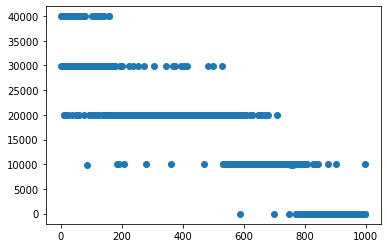

In [202]:
plt.scatter(range(len(losses)), losses)
plt.show()